In [ ]:
import torchvision
from fastai.vision.all import *

# Fine-Tuning Pretrained Networks for Image Classification

Training image classification models from scratch requires a fair amount of time and data. So, we try to avoid doing this wherever possible! Instead, transfer learning is a process for taking a model that has already been trained on one task (such as classification on the Imagenet dataset) and adapting it for a new, usually related, task. 

Before we look at doing this from scratch, let me show you my favourite library for transfer learning in action, with an example lifted straight from the [fast.ai docs](https://docs.fast.ai/tutorial.vision.html):

### Loading the data

Fastai dataloaders are very powerful and flexible, but ultimately their job is to give us batches of data:

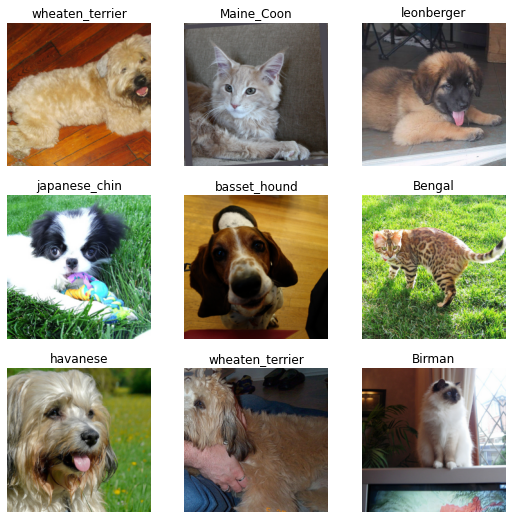

In [ ]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")
pat = r'^(.*)_\d+.jpg' # What is this magic?
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))
dls.show_batch()

### Creating And Training The Model

Here in a few lines of code we 
- Create a model based on a pretrained Resnet34 model
- Run a test to help us pick a good learning rate
- Fine-tune the model on our dataset to an accuracy of ~92%

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(valley=0.0006918309954926372)

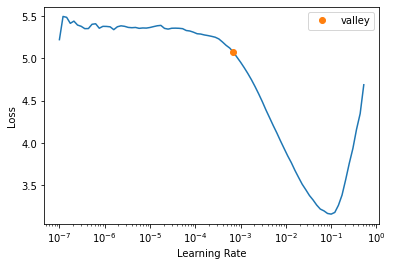

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(2, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.273223,0.332054,0.112991,00:59


epoch,train_loss,valid_loss,error_rate,time
0,0.545924,0.513807,0.143437,01:19
1,0.332779,0.249293,0.079838,01:17


### Results

Besides reading off the error rate from the output above (which is calculated on an automatically-created validation set) we can also view some raw model predictions:

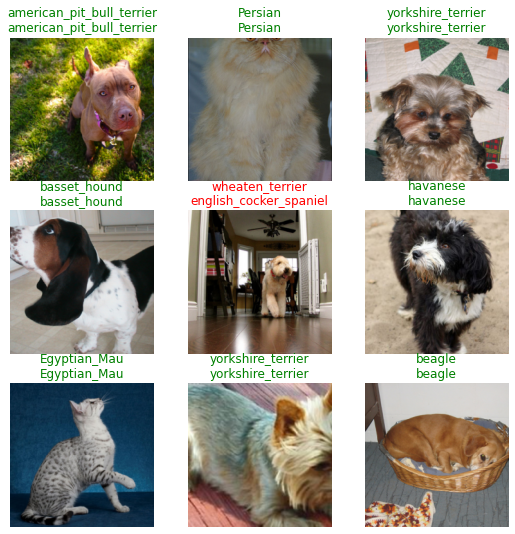

In [ ]:
learn.show_results()

And see the cases where the model was most wrong:

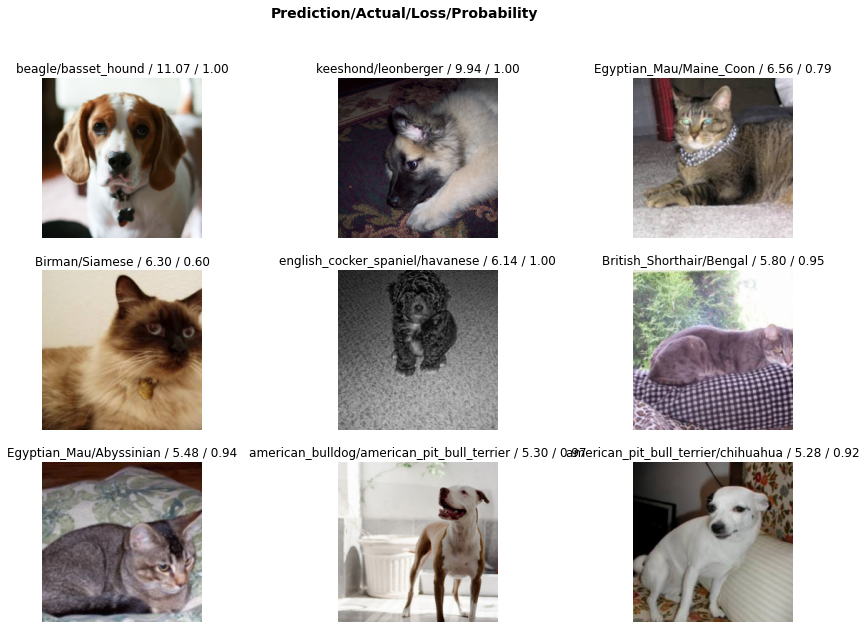

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

Pretty impressive! This course isn't going to teach fast.ai since it has its own [excellent free course](https://course.fast.ai) that will do it much better! If you're excited about learning how to do deep learning tasks like image classification extremely well you should definitely check it out. In fact even if you aren't I highly recommend giving it a go - the FastAI course is what got me into deep learning and everyone I've spoken to who has done it has benefitted massively from doing so.

To start understanding what is going on in those magical few lines above, we can try reading some of the code:

In [ ]:
# ??learn.fine_tune

In [ ]:
# ??learn.fit_one_cycle

## Replicating (some of) this in PyTorch

What would this look like in raw PyTorch? Let's clear out some GPU memory and then try to replicate the result above:

In [ ]:
import gc
del learn
gc.collect()
torch.cuda.empty_cache()

The first component is the dataloaders. In addition to loading the images, resizing and normalizing the data, reading in the labels and so on, the dataloaders also do something called 'data augmentation', where each image is randomly transformed using a user-specified list of possible transforms (we use the pre-defined `aug_transforms` above). This means that every time we get a batch of data we'll see the model inputs (images that have been scaled and transformed with some augmentation) and the labels:

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb

(torch.Size([64, 3, 224, 224]),
 TensorCategory([15,  1, 23, 20,  7,  7, 26, 30, 27, 22, 27,  2, 15,  0,  2, 31,
                 24, 10,  2,  4, 33, 22, 28,  0, 27, 16, 34, 19,  7, 16,  6, 18,
                  2,  3, 27, 26, 30, 28, 13, 18, 28, 16, 31, 19, 21, 19, 14,  3,
                 13, 15, 27,  2,  2, 24,  0, 27, 32, 13, 34, 19, 23,  5, 25, 10],
                device='cuda:0'))

If you want to see the string versions of the labels, you can look them up in dls.vocab:

In [ ]:
len(dls.vocab), dls.vocab

(37,
 ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier'])

We'll just use the dataloaders here rather than re-creating them ourselves. The more intersting bit is: how do we turn a model trained on 1000 imagenet classes into one capable of classifying 37 dog breeds?

First, we load the pretrained model:

In [ ]:
model = resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)

Then we replace the final fully connected layer (model.fc, although the naming will vary depending on your choice of model/architecture) with our own new layer. This gives us a modified version of the model with 37 outputs: 

In [ ]:
model.fc = nn.Linear(512, 37)
model.to(xb.device)
with torch.no_grad():
    preds = model(xb)
preds.shape

torch.Size([64, 37])

In [ ]:
# model # Uncomment to view the full model

We can train this with cross entropy loss (see Lesson 3):

In [ ]:
loss_fn = CrossEntropyLossFlat()
loss_fn(preds, yb)

TensorBase(3.8790, device='cuda:0')

Importantly, the final layer we added has been initialized with random parameters, so we should probably train those a bit first, without modifying the rest of the model too drastically. After all, it has already learnt lots of useful features and we wouldn't want to mess it up while this random final layer was not making good use of them. To do this, we freeze all the rest of the model parameters (setting requires_grad to False) and train for one epoch:

In [ ]:
[p.shape for p in model.fc.parameters()]

[torch.Size([37, 512]), torch.Size([37])]

In [ ]:
losses = []

# Freeze all layers (requires_grad=False)
for p in model.parameters():
    p.requires_grad = False

# Unfreeze final layer
for p in model.fc.parameters():
    p.requires_grad= True

# Optimizer on just these unfrozen parameters
opt = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

# Train for one epoch
for xb, yb in dls.train:
    preds = model(xb)
    loss = loss_fn(preds, yb)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()

Plotting the losses:

[<matplotlib.lines.Line2D>]

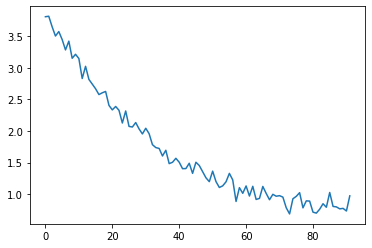

In [ ]:
plt.plot(losses)

Now we can unfreeze the rest of the parameters and train a bit longer, using a lower learning rate:

In [ ]:
# Unfreeze the rest of the model parameters
for p in model.parameters():
    p.requires_grad = True

# New optimizer and train a bit more at a lower learning rate
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
for xb, yb in dls.train:
    preds = model(xb)
    loss = loss_fn(preds, yb)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()

Plotting the losses, showing this second epoch in yellow:

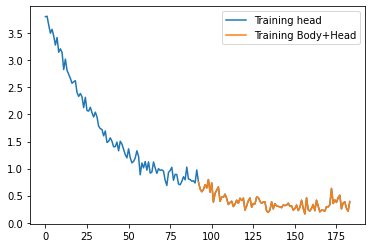

In [ ]:
#|hide    
plt.plot(losses, label = 'Training head')
l = len(dls.train)
plt.plot(range(l, l*2), losses[-l:], label='Training Body+Head')
plt.legend();

You could train for multiple epochs, explore using some sort of learning rate schedule and otherwise tweak this training procedure to try to improve performance further. But before you do, let's see how we might calculate accuracy on the validation set:

In [ ]:
#|hide
right = 0
total = 0
for xb, yb in dls.valid:
    with torch.no_grad():
        preds = model(xb)
    pred_labels = preds.argmax(dim=1)
    right += (yb.cpu().numpy() == pred_labels.cpu().numpy()).sum() # Quick and dirty check count of how many preds in pred_labels match the true labels in yb
    total += yb.shape[0] # The total number of examples in this batch

print(f'Accuracy on validation set: {100*right/total:.2f}%')

Accuracy on validation set: 91.07%


Not bad! It is pretty convenient to have all of these features (automatic evaluation of metrics, data augmentation, learning rate schedules, tracking model freezing/unfreezing...) built into fastai, but they aren't magic - we can totally do these ourselves too! 

TODO script doing this all from scratch in PyTorch

TODO talk about how having logging is nicer than waiting for a training loop to finish before you can see stats

TODO Add a bit more explanation